## 9. **Dropout**

- **Overfitting(**학습 데이터에는 성능이 좋지만, 테스트 데이터에선 성능이 떨어지는 현상) 방지를 위한 대표적인 정규화 기법
    
    → 학습(`train`) 시에만 적용되고, 추론(`test`) 시에는 사용하지 않음
    
    → 해결: **Regularization** (batch, early stopping, weight decay 등이 추가로 존재)
    
- 학습 중에 일부 뉴런을 **무작위로 제거(drop)** 하여, 특정 뉴런에 **과도하게 의존하는 것을 방지**
    
    ⇒ **매 `forward` pass마다 dropout mask를 새로 생성**
    
- **살아남은 뉴런은 출력값을 2배로 스케일링하여** 다음 레이어로 전달
    
    ⇒ **평균 출력을 유지하기 위한 조치 (Expected Value 보존)**
    
- 물론 가장 좋은 방법은 데이터의 확보!!

In [54]:
import pandas as pd

df = pd.read_csv('data/swirl_10k.csv')

data = df[['x', 'y']].values
labels = df['label'].values.reshape(-1, 1)

print(f'data: {data}, labels: {labels}')


data: [[-0.30249982  0.35228178]
 [-0.89796171  0.10499859]
 [-0.53929324 -0.17153895]
 ...
 [ 0.52112207 -0.09355757]
 [-0.10692036 -0.50632611]
 [ 0.33397909  0.69549823]], labels: [[1.]
 [0.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


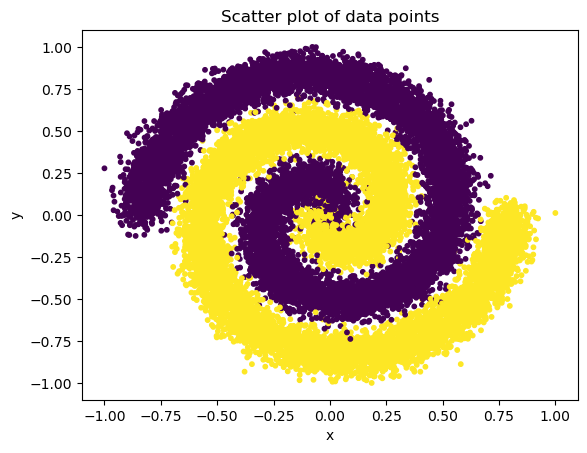

In [55]:
import matplotlib.pyplot as plt

plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=10)
plt.title('Scatter plot of data points')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [57]:
import torch
import torch.nn.functional as F

data_torch = torch.tensor(data, dtype=torch.float32)
labels_torch = torch.tensor(labels, dtype=torch.float32)

# 학습데이터를 7:3 정도로 train/validation으로 나누기
data_length = len(data_torch)
split_n = int(data_length * 0.7)
train_data = data_torch[:split_n]
train_labels = labels_torch[:split_n]
val_data = data_torch[split_n:]
val_labels = labels_torch[split_n:]


In [58]:
g = torch.Generator().manual_seed(42)

# 배치로 데이터를 묶음(mini-batch)
def get_batch(x, y, batch_size):
  data_length = len(x)
  indices = torch.randint(0, data_length, (batch_size,), generator=g)

  x_batch = x[indices]
  y_batch = y[indices]
  return x_batch, y_batch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim 

g.manual_seed(42)
torch.manual_seed(42)

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()

    # nn.Sequential을 사용하여 여러 레이어를 연결
    self.seq_model = nn.Sequential(
      nn.Linear(input_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, output_size)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.seq_model(x)
  

net = Net(2, 16, 1)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for steps in range(100000):
  net.train()
  data_batch, label_batch = get_batch(train_data, train_labels, 256)
  output = net(data_batch)
  
  loss = loss_fn(output, label_batch)

  loss.backward()
  optimizer.step()

  optimizer.zero_grad()

  if steps % 1000 == 0:
    net.eval()
    output = net(val_data)

    val_loss = loss_fn(output, val_labels)
    print(f"{steps} val_loss: {val_loss.item()}")


0 val_loss: 0.6951373815536499
1000 val_loss: 0.6907992362976074
2000 val_loss: 0.6850731372833252
3000 val_loss: 0.6618578433990479
4000 val_loss: 0.6212738156318665
5000 val_loss: 0.6037871241569519
6000 val_loss: 0.5919691324234009
7000 val_loss: 0.5688795447349548
8000 val_loss: 0.5197105407714844
9000 val_loss: 0.4441169500350952
10000 val_loss: 0.370625376701355
11000 val_loss: 0.282582551240921
12000 val_loss: 0.22360028326511383
13000 val_loss: 0.17338310182094574
14000 val_loss: 0.14814263582229614
15000 val_loss: 0.1355130970478058
16000 val_loss: 0.12489558756351471
17000 val_loss: 0.11054062098264694
18000 val_loss: 0.12962372601032257
19000 val_loss: 0.09488057345151901
20000 val_loss: 0.09214732050895691
21000 val_loss: 0.08328469097614288
22000 val_loss: 0.08877655863761902
23000 val_loss: 0.07427757978439331
24000 val_loss: 0.07371601462364197
25000 val_loss: 0.06610876321792603
26000 val_loss: 0.06559943407773972
27000 val_loss: 0.07126481831073761
28000 val_loss: 0.05

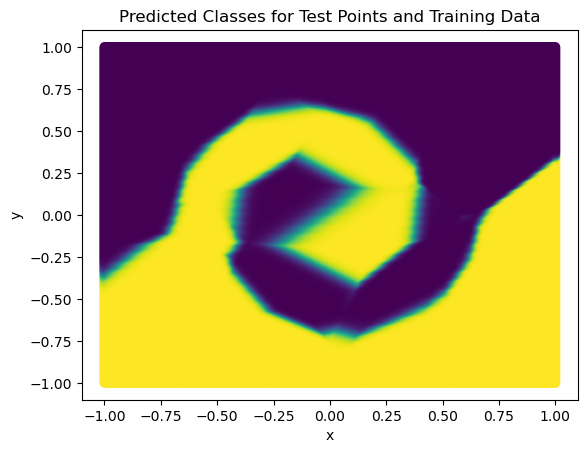

In [79]:
import numpy as np
import matplotlib.pyplot as plt

n_points = 300
x_points = np.linspace(-1, 1, n_points)
y_points = np.linspace(-1, 1, n_points)
x, y = np.meshgrid(x_points, y_points)
test_points = np.vstack((x.flatten(), y.flatten())).T

test_points_torch = torch.from_numpy(test_points).float()

net.eval()
output = net(test_points_torch)

probabilities = torch.sigmoid(output)
probabilities_np = probabilities.detach().numpy()

plt.scatter(test_points[:, 0], test_points[:, 1], c=probabilities_np, cmap='viridis')
plt.title('Predicted Classes for Test Points and Training Data')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim 

g.manual_seed(42)
torch.manual_seed(42)

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()

    # dropout을 사용하여 과적합 방지
    self.seq_model = nn.Sequential(
      nn.Linear(input_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(hidden_size, output_size)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.seq_model(x)
  

net = Net(2, 16, 1)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for steps in range(100000):
  net.train()
  data_batch, label_batch = get_batch(train_data, train_labels, 256)
  output = net(data_batch)
  
  loss = loss_fn(output, label_batch)

  loss.backward()
  optimizer.step()

  optimizer.zero_grad()

  if steps % 1000 == 0:
    net.eval()
    output = net(val_data)

    val_loss = loss_fn(output, val_labels)
    print(f"{steps} val_loss: {val_loss.item()}")


0 val_loss: 0.6951403617858887
1000 val_loss: 0.6916131377220154
2000 val_loss: 0.6891796588897705
3000 val_loss: 0.6829337477684021
4000 val_loss: 0.6671044230461121
5000 val_loss: 0.6484845876693726
6000 val_loss: 0.6374170780181885
7000 val_loss: 0.6289548277854919
8000 val_loss: 0.6199846267700195
9000 val_loss: 0.6038526296615601
10000 val_loss: 0.5774194598197937
11000 val_loss: 0.5457779765129089
12000 val_loss: 0.5233768820762634
13000 val_loss: 0.5091387629508972
14000 val_loss: 0.4987950026988983
15000 val_loss: 0.4899625778198242
16000 val_loss: 0.4832361936569214
17000 val_loss: 0.47877487540245056
18000 val_loss: 0.4731011986732483
19000 val_loss: 0.45928123593330383
20000 val_loss: 0.437453031539917
21000 val_loss: 0.3826386034488678
22000 val_loss: 0.36867350339889526
23000 val_loss: 0.3586213290691376
24000 val_loss: 0.35098665952682495
25000 val_loss: 0.33690646290779114
26000 val_loss: 0.3261392116546631
27000 val_loss: 0.3076217770576477
28000 val_loss: 0.29212209582

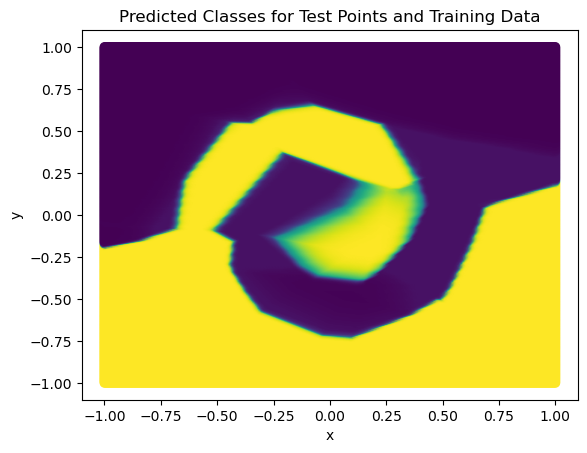

In [76]:
import numpy as np
import matplotlib.pyplot as plt

n_points = 300
x_points = np.linspace(-1, 1, n_points)
y_points = np.linspace(-1, 1, n_points)
x, y = np.meshgrid(x_points, y_points)
test_points = np.vstack((x.flatten(), y.flatten())).T

test_points_torch = torch.from_numpy(test_points).float()

net.eval()
output = net(test_points_torch)

probabilities = torch.sigmoid(output)
probabilities_np = probabilities.detach().numpy()

plt.scatter(test_points[:, 0], test_points[:, 1], c=probabilities_np, cmap='viridis')

plt.title('Predicted Classes for Test Points and Training Data')
plt.xlabel('x')
plt.ylabel('y')

plt.show()